# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01


In [41]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import pandas as pd

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [5]:
cursor = con.cursor()
sql = """
SELECT MAX(hire_date),MIN(hire_date)
FROM employees
"""
cursor.execute(sql)
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [35]:
cursor = con.cursor()
sql = """
SELECT DISTINCT emp_no, salary, from_date, to_date
FROM salaries 
WHERE (emp_no, to_date, from_date) IN (
    SELECT emp_no, MAX(to_date), MAX(from_date)
    FROM salaries
    GROUP BY emp_no
);
"""
cursor.execute(sql)

In [27]:
res = pd.DataFrame(cursor.fetchall(), columns = field_names )
print(res.shape)
print(res.columns)
res.head(3)

(300024, 4)
Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')


,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


In [23]:
field_names = [i[0] for i in cursor.description]
field_names

['emp_no', 'salary', 'from_date', 'to_date']

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [37]:
from datetime import date
res = pd.DataFrame(cursor.fetchall(), columns =['emp_no', 'salary', 'from_date', 'to_date'] )
count_9999 = res[res.to_date == date(9999, 1, 1)].shape[0]
count_no_9999 = res[res.to_date != date(9999, 1, 1)].shape[0]
print(f"Кількість значень, рівних 9999-01-01: {count_9999}")
print(f"Кількість значень, не рівних 9999-01-01: {count_no_9999}")

Кількість значень, рівних 9999-01-01: 240124
Кількість значень, не рівних 9999-01-01: 59900


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [125]:
import matplotlib.pyplot as plt

In [161]:
cursor = con.cursor()
sql = """
SELECT emp_no, salary, from_date, to_date
FROM salaries 
WHERE to_date = "9999-01-01";
"""
cursor.execute(sql)

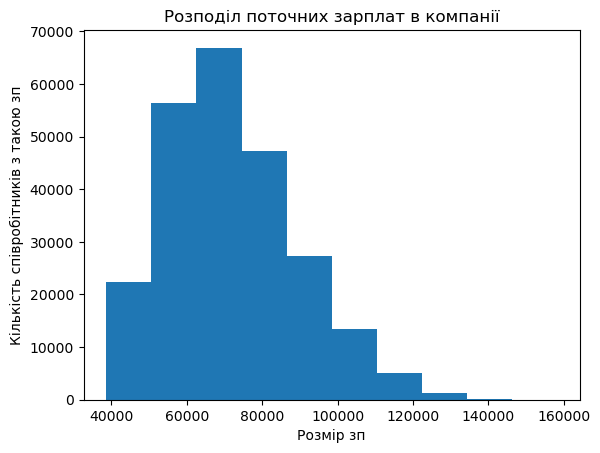

In [163]:
df = pd.DataFrame(cursor.fetchall(), columns = ['emp_no', 'salary', 'from_date', 'to_date'] )
plt.hist(df.salary)
plt.title("Розподіл поточних зарплат в компанії")
plt.xlabel('Розмір зп')
plt.ylabel('Кількість співробітників з такою зп');

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [39]:
con.close()